Problem Statement : 

One of the largest retail chains in the world wants to use their vast data source to build an efficient forecasting model to predict the sales for each SKU in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis. Sales and promotional information is also available for each week - product and store wise. 

However, no other information regarding stores and products are available. So we need to forecast accurately the sales values for every such product/SKU-store combination for the next 12 weeks accurately.

Data Description

Variable | Definition

record_ID           | Unique ID for each week store sku combination
week                  | Starting Date of the week
store_id              | Unique ID for each store (no numerical order to be assumed)
sku_id                | Unique ID for each product (no numerical order to be assumed)
total_price        | Sales Price of the product
base_price       | Base price of the product
is_featured_sku | Was part of the featured item of the week
is_display_sku   | Product was on display at a prominent place at the store
units_sold          | (Target) Total Units sold for that week-store-sku combination

In [2]:
#importing important libraries
import numpy as np
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
#importing train and test dataset
df_train=pd.read_csv("train_data.csv")
df_test=pd.read_csv("test_data.csv")

In [4]:
df_train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [5]:
#shape of dataset
df_train.shape

(150150, 9)

In [6]:
#checking data types of features
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


*  we will extract week,months and years from the date format columns for better insight.

In [7]:
#splitting the date column as linear regression does not handle date format column
df_train['year'] = pd.to_datetime(df_train['week']).dt.year
df_train['month'] = pd.to_datetime(df_train['week']).dt.month
df_train['week_num'] = pd.to_datetime(df_train['week']).dt.week

In [8]:
#store id and product id should be in category
df_train['sku_id'] = df_train['sku_id'].astype('category')
df_train['store_id'] = df_train['store_id'].astype('category')

In [9]:
df_train.describe()

,record_ID,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,week_num
count,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,206.626751,219.425927,0.095611,0.133200,51.674206,2011.830769,6.130769,24.992308
std,61386.037861,103.308516,110.961712,0.294058,0.339792,60.207904,0.755887,3.438232,14.867927
min,1.000000,41.325000,61.275000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000
25%,53111.250000,130.387500,133.237500,0.000000,0.000000,20.000000,2011.000000,3.000000,12.000000
50%,106226.500000,198.075000,205.912500,0.000000,0.000000,35.000000,2012.000000,6.000000,23.500000
75%,159452.750000,233.700000,234.412500,0.000000,0.000000,62.000000,2012.000000,9.000000,38.000000
max,212644.000000,562.162500,562.162500,1.000000,1.000000,2876.000000,2013.000000,12.000000,52.000000


* On an average the product was neither part of the featured item of the week nor the Product was on display at a prominent place at the store


# Exploratory Data Analysis (EDA)

In [10]:
#checking unique store
df_train['store_id'].nunique()

76

In [11]:
#checking unique products
df_train['sku_id'].nunique()

28

* There are only 76 store and 28 unique products across the store.

In [12]:
#checking frequency of product which was part of the featured item of the week .
df_train['is_featured_sku'].value_counts()

0    135794
1     14356
Name: is_featured_sku, dtype: int64



* only 9.56% products was part of feature item of the week.

In [13]:
#checking frequency of Product which was on display at a prominent place at the store.
df_train['is_display_sku'].value_counts()

0    130150
1     20000
Name: is_display_sku, dtype: int64

* similar trend to featuring of products,only 13.32% of products that displayed at a prominent place at store contribute to unit sold.

## Univariate Analysis

Text(0.5, 1.0, 'unit sold Distribution')

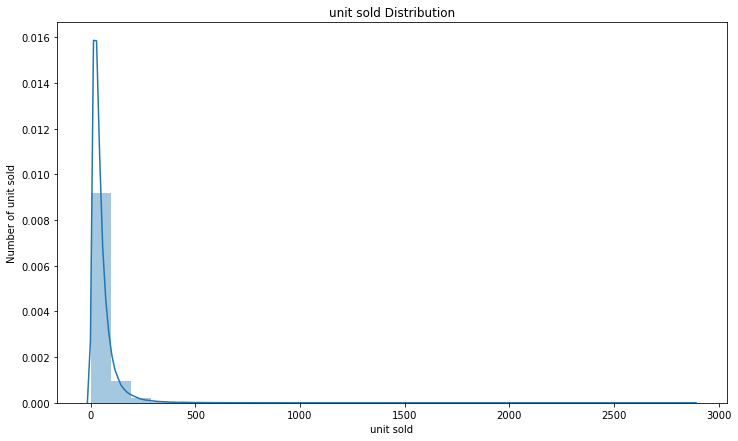

In [14]:
# Distribution of the target variable
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(12,7))
sns.distplot(df_train.units_sold, bins = 30)
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,1))
plt.xlabel("unit sold")
plt.ylabel("Number of unit sold")
plt.title("unit sold Distribution")

In [15]:
print ("Skew is:", df_train.units_sold.skew())
print("Kurtosis: %f" % df_train.units_sold.kurt())

Skew is: 6.114995824093101
Kurtosis: 93.686253


* We can see that our target variable is skewed to the right, towards the higher sales, with higher concentration on lower number of unit sold.
* Higher kurtosis here signifies that it has heavy tails, or outliers.

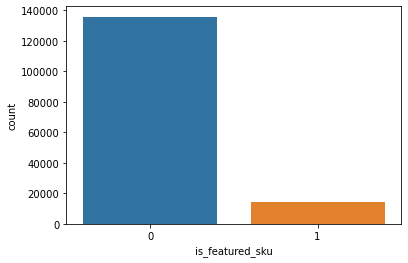

In [16]:
# count plot on single categorical variable
sns.countplot(x ='is_featured_sku', data = df_train)
# Show the plot
plt.show()

* The count for non featured item is much more than the featured item

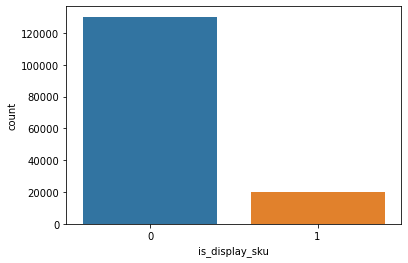

In [17]:
# count plot on single categorical variable
sns.countplot(x ='is_display_sku', data = df_train)
# Show the plot
plt.show()

* Similar to above trend,the count of Product was which was on display at a prominent place at the  is very low.

<AxesSubplot:xlabel='base_price', ylabel='Density'>

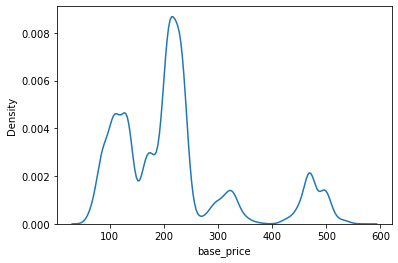

In [18]:
#kde plot for base price
sns.kdeplot(df_train['base_price'])



* The mamimum frequency of base price is along 230-250.

<AxesSubplot:xlabel='total_price', ylabel='Density'>

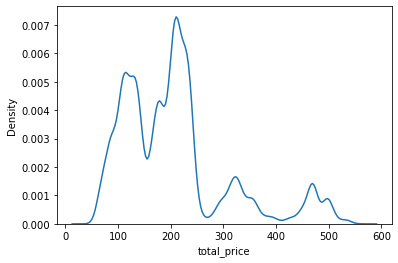

In [19]:
#kde plot for total price
sns.kdeplot(df_train['total_price'])

* The freqency of total price is also following similar trend,that is along 230-250.

# Bivariate Analysis

<AxesSubplot:xlabel='base_price', ylabel='units_sold'>

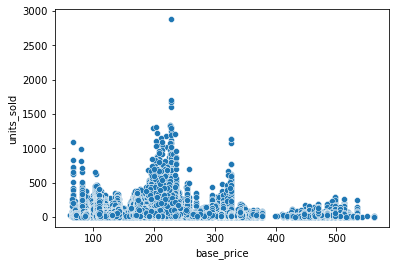

In [20]:
#base price vs unit sold
import seaborn
seaborn.scatterplot(x="base_price",
                    y="units_sold",
                    data=df_train)

<AxesSubplot:xlabel='total_price', ylabel='units_sold'>

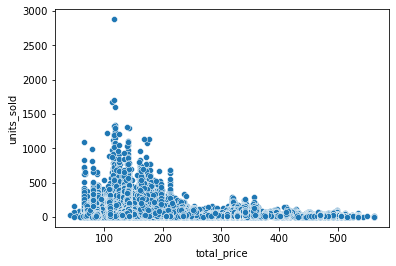

In [21]:
#total price vs unit sold
seaborn.scatterplot(x="total_price",
                    y="units_sold",
                    data=df_train)

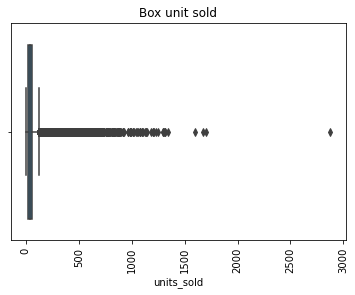

In [22]:
#outliers
sns.boxplot( x='units_sold', data=df_train)
plt.xticks(rotation=90)
plt.title("Box unit sold")
plt.show()

In [23]:
#will see what is that highest outliered row

df_train[df_train["units_sold"] == df_train["units_sold"].max()]


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,week_num
5607,7961,14/02/11,9845,219009,116.85,227.2875,1,1,2876,2011,2,7


* The maximum value outliers may be due to high discount.

Text(0, 0.5, 'Units Sold')

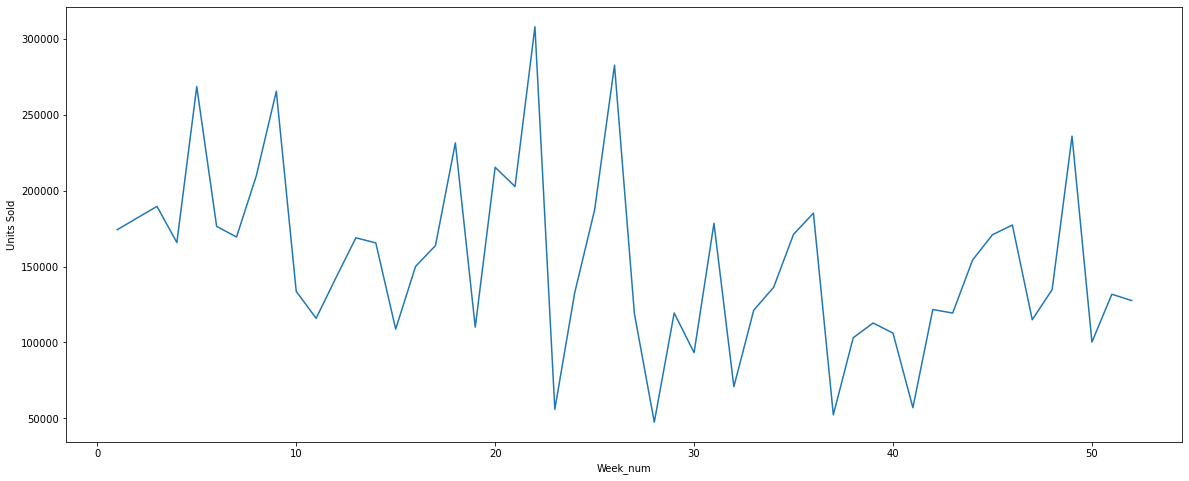

In [24]:
#trends of unit sold across week
df_train.groupby('week_num').sum()['units_sold'].plot(figsize = (20,8))
plt.xlabel("Week_num")
plt.ylabel("Units Sold")

Text(0, 0.5, 'Units Sold')

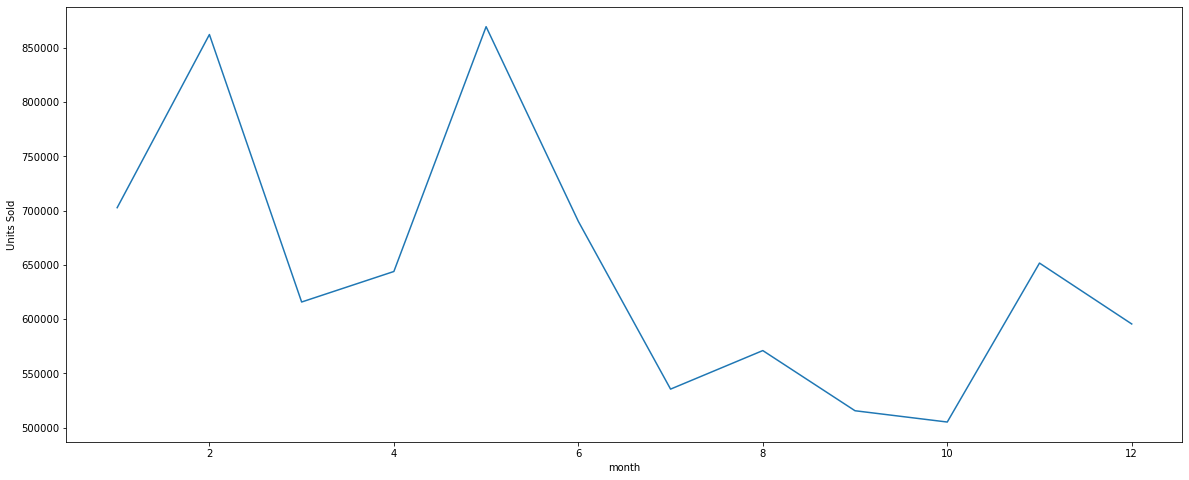

In [25]:
#trends of unit sold across months
df_train.groupby('month').sum()['units_sold'].plot(figsize = (20,8))
plt.xlabel("month")
plt.ylabel("Units Sold")

Text(0, 0.5, 'Units Sold')

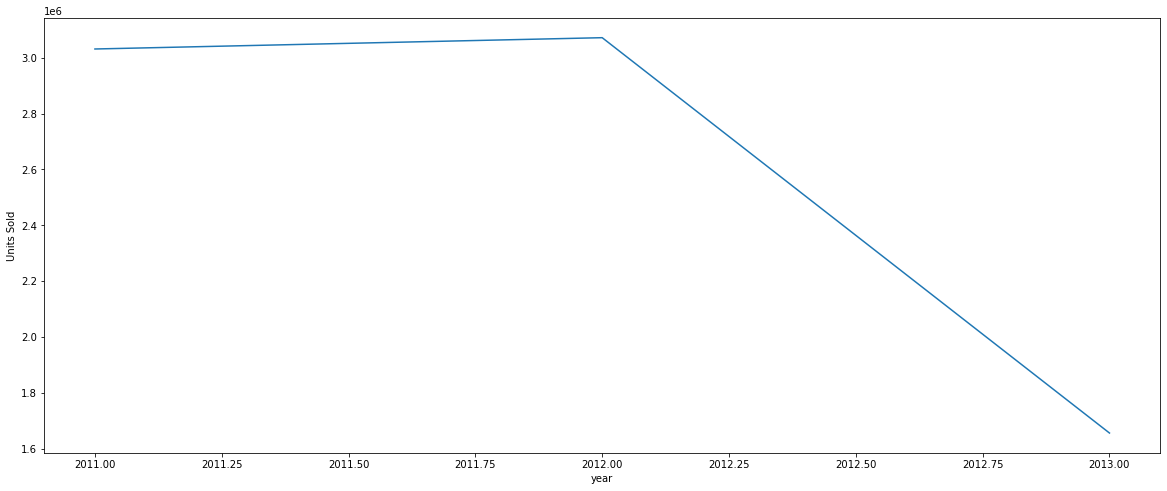

In [26]:
#trends of unit sold across year
df_train.groupby('year').sum()['units_sold'].plot(figsize = (20,8))
plt.xlabel("year")
plt.ylabel("Units Sold")

Text(0, 0.5, 'Units Sold')

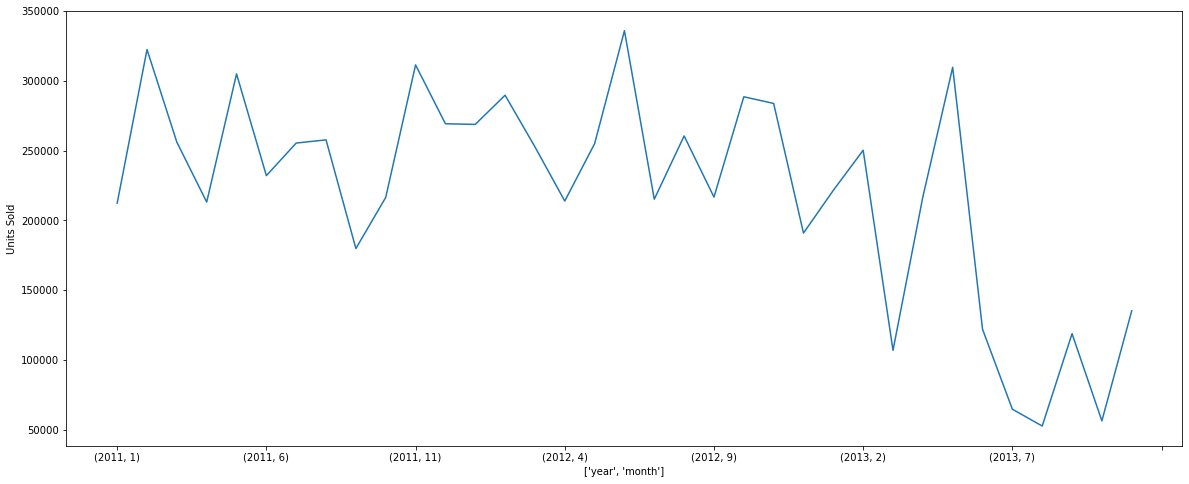

In [27]:
#trends of unit sold across year and months
df_train.groupby(['year','month']).sum()['units_sold'].plot(figsize = (20,8))
plt.xlabel(["year","month"])
plt.ylabel("Units Sold")

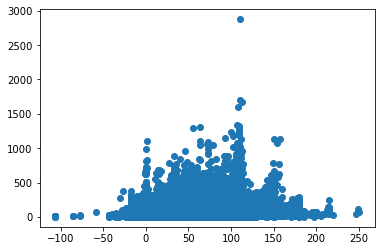

In [28]:
#finding out the discount
df_train['discount'] = df_train['base_price'] - df_train['total_price']
df_test['discount'] = df_test['base_price'] - df_test['total_price']
plt.scatter(df_train['discount'],df_train['units_sold'],label = 'discount')

* The maximum count of unit sold is at a discount of 110.

In [29]:
#checking null values
df_train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
year               0
month              0
week_num           0
discount           1
dtype: int64

In [30]:
#dropping null values
df_train.dropna()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,week_num,discount
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20,2011,1,3,12.8250
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28,2011,1,3,0.0000
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19,2011,1,3,0.0000
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44,2011,1,3,0.0000
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52,2011,1,3,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38,2013,9,36,0.0000
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30,2013,9,36,0.0000
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31,2013,9,36,126.1125
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12,2013,9,36,49.8750


In [31]:
#checking null values in test data
df_test.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
discount           0
dtype: int64

# Outliers Treatment

<AxesSubplot:>

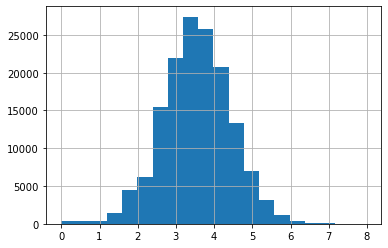

In [32]:
df_train['units_sold_log'] = np.log(df_train['units_sold'])
df_train['units_sold_log'].hist(bins=20) 
#df_test['units_sold_log'] = np.log(df_test['units_sold'])

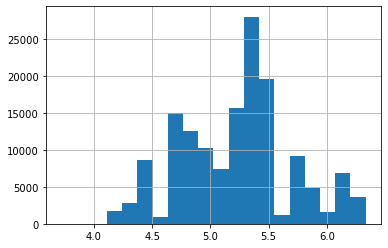

In [33]:
df_train['total_price_log'] = np.log(df_train['total_price'])
df_train['total_price_log'].hist(bins=20) 
df_test['total_price_log'] = np.log(df_test['total_price'])

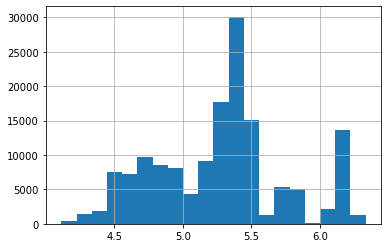

In [34]:
df_train['base_price_log'] = np.log(df_train['base_price'])
df_train['base_price_log'].hist(bins=20) 
df_test['base_price_log'] = np.log(df_test['base_price'])
df_train['discount_log'] = np.log(df_train['discount'])
df_test['discount_log'] = np.log(df_test['discount'])


In [35]:
#making copy
df_train_new=df_train.copy() 
df_test_new=df_test.copy()

In [36]:
#importing linear regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
from datetime import datetime 
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [37]:
#dropping unwanted column
df_train.drop('record_ID',axis=1)

,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,week_num,discount,units_sold_log,total_price_log,base_price_log,discount_log
0,17/01/11,8091,216418,99.0375,111.8625,0,0,20,2011,1,3,12.8250,2.995732,4.595499,4.717270,2.551396
1,17/01/11,8091,216419,99.0375,99.0375,0,0,28,2011,1,3,0.0000,3.332205,4.595499,4.595499,-inf
2,17/01/11,8091,216425,133.9500,133.9500,0,0,19,2011,1,3,0.0000,2.944439,4.897467,4.897467,-inf
3,17/01/11,8091,216233,133.9500,133.9500,0,0,44,2011,1,3,0.0000,3.784190,4.897467,4.897467,-inf
4,17/01/11,8091,217390,141.0750,141.0750,0,0,52,2011,1,3,0.0000,3.951244,4.949292,4.949292,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,09/07/13,9984,223245,235.8375,235.8375,0,0,38,2013,9,36,0.0000,3.637586,5.463143,5.463143,-inf
150146,09/07/13,9984,223153,235.8375,235.8375,0,0,30,2013,9,36,0.0000,3.401197,5.463143,5.463143,-inf
150147,09/07/13,9984,245338,357.6750,483.7875,1,1,31,2013,9,36,126.1125,3.433987,5.879625,6.181646,4.837174
150148,09/07/13,9984,547934,141.7875,191.6625,0,1,12,2013,9,36,49.8750,2.484907,4.954329,5.255736,3.909520


In [38]:
df_train.Timestamp = pd.to_datetime(df_train["week"]) 
df_train.index = df_train.Timestamp 
#df_train['week'] = pd.to_numeric(pd.to_datetime(df_train['week']))

 
# # Converting to monthly mean and weekly mean.
#monthly = df_train.resample(rule='M').mean()
#weekly = df_train.resample(rule='W').mean()

In [39]:
Training=df_train.loc['2011-01-17':'2013-04-09'] 
validating=df_train.loc['2013-04-10':'2013-07-09']

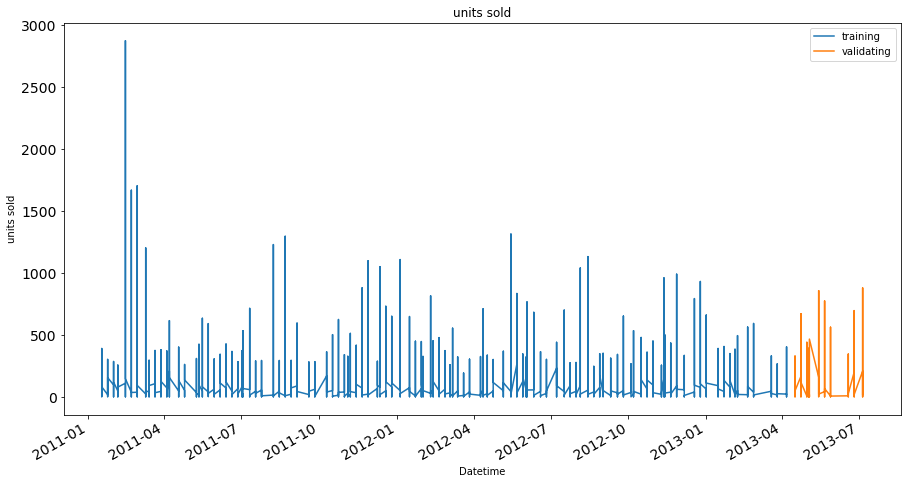

In [40]:
Training['units_sold'].plot(figsize=(15,8), title= 'units sold', fontsize=14, label='training') 
validating['units_sold'].plot(figsize=(15,8), title= 'units sold', fontsize=14, label='validating') 
plt.xlabel("Datetime") 
plt.ylabel("units sold") 
plt.legend(loc='best') 
plt.show()

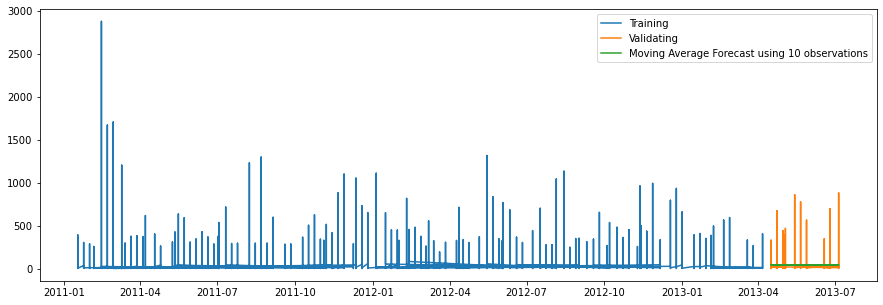

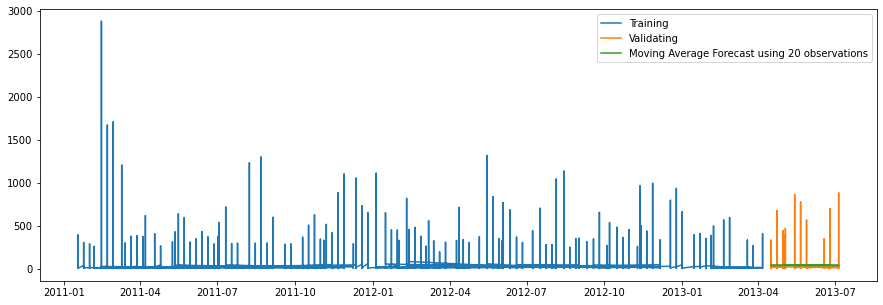

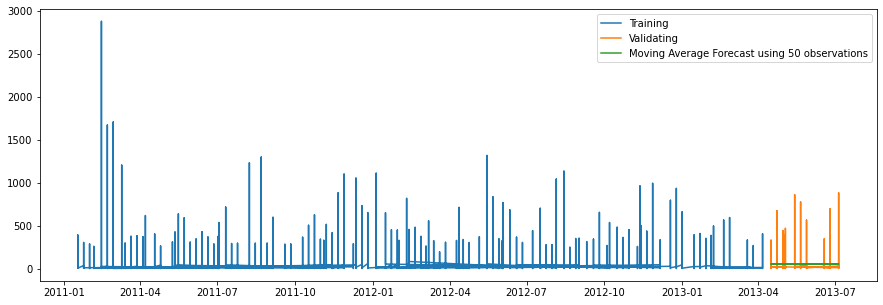

In [41]:
y_hat_avg = validating.copy() 
y_hat_avg['moving_avg_forecast'] = Training['units_sold'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Training['units_sold'], label='Training') 
plt.plot(validating['units_sold'], label='Validating') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 
y_hat_avg = validating.copy() 
y_hat_avg['moving_avg_forecast'] = Training['units_sold'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Training['units_sold'], label='Training') 
plt.plot(validating['units_sold'], label='Validating') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 
y_hat_avg = validating.copy() 
y_hat_avg['moving_avg_forecast'] = Training['units_sold'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Training['units_sold'], label='Training') 
plt.plot(validating['units_sold'], label='Validating') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()


In [42]:
#df_train['total_price']= df_train['total_price'].fillna(df_train['total_price'].median())
#x_train = x_train.replace((np.inf, -np.inf, np.nan),0).reset_index(drop=True)
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [43]:
df_train.fillna(df_train.median(), inplace=True)

In [44]:
X_train=df_train[["store_id","sku_id","is_featured_sku","is_display_sku","year","month","week_num","discount","total_price_log","base_price_log","discount_log"]]
Y_train=df_train[["units_sold"]]

In [45]:
X_train=X_train.reset_index()
X_train=X_train.drop(['week'],axis=1)
X_train

,store_id,sku_id,is_featured_sku,is_display_sku,year,month,week_num,discount,total_price_log,base_price_log,discount_log
0,8091,216418,0,0,2011,1,3,12.8250,4.595499,4.717270,2.551396
1,8091,216419,0,0,2011,1,3,0.0000,4.595499,4.595499,3.552845
2,8091,216425,0,0,2011,1,3,0.0000,4.897467,4.897467,3.552845
3,8091,216233,0,0,2011,1,3,0.0000,4.897467,4.897467,3.552845
4,8091,217390,0,0,2011,1,3,0.0000,4.949292,4.949292,3.552845
...,...,...,...,...,...,...,...,...,...,...,...
150145,9984,223245,0,0,2013,9,36,0.0000,5.463143,5.463143,3.552845
150146,9984,223153,0,0,2013,9,36,0.0000,5.463143,5.463143,3.552845
150147,9984,245338,1,1,2013,9,36,126.1125,5.879625,6.181646,4.837174
150148,9984,547934,0,1,2013,9,36,49.8750,4.954329,5.255736,3.909520


In [46]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,Y_train)
r2_score = regressor.score(X_train,Y_train)
print(r2_score*100,'%')

28.778413619853318 %


In [47]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error as msle
from math import sqrt

rms = sqrt(mean_squared_error(validating.units_sold, y_hat_avg.moving_avg_forecast)) 
print("rms: ",rms)
rmsle = sqrt(msle(validating.units_sold, y_hat_avg.moving_avg_forecast)) 

print("rmsle: ",rmsle)

rms:  58.52834712948558
rmsle:  0.9912297880842251


In [48]:
#splitting the date column as linear regression does not handle date format column
df_test['year'] = pd.to_datetime(df_test['week']).dt.year
df_test['month'] = pd.to_datetime(df_test['week']).dt.month
df_test['week_num'] = pd.to_datetime(df_test['week']).dt.week

In [49]:
df_test=df_test.drop(['record_ID'],axis=1)
df_test=df_test.drop(['week'],axis=1)

In [50]:
df_test.replace([np.inf, -np.inf],np.nan,  inplace=True)
df_test.fillna(df_test.median(), inplace=True)

In [51]:
#store id and product id should be in category
df_test['sku_id'] = df_test['sku_id'].astype('category')
df_test['store_id'] = df_test['store_id'].astype('category')

In [52]:
df_test=df_test[["store_id","sku_id","is_featured_sku","is_display_sku","year","month","week_num","discount","total_price_log","base_price_log","discount_log"]]



In [53]:
from sklearn.linear_model import LinearRegression as lr
# getting RMSLE values
model = lr()
model.fit(X_train,Y_train)
#df_test['week'] = pd.to_numeric(pd.to_datetime(df_test['week']))
# getting the predicted sales value 
prediction = model.predict(df_test)
# creating a new variable called prediction in test data
df_test['predicted_units_sold'] = prediction
df_test.head()

,store_id,sku_id,is_featured_sku,is_display_sku,year,month,week_num,discount,total_price_log,base_price_log,discount_log,predicted_units_sold
0,8091,216418,0,0,2013,7,29,0.0,4.684905,4.684905,3.755369,55.722916
1,8091,216419,0,0,2013,7,29,0.0,4.691463,4.691463,3.755369,55.606138
2,8091,216425,0,0,2013,7,29,0.0,4.897467,4.897467,3.755369,51.940437
3,8091,216233,0,0,2013,7,29,0.0,4.897467,4.897467,3.755369,51.962688
4,8091,217390,0,0,2013,7,29,0.0,5.174453,5.174453,3.755369,46.900744
